In [8]:
import sys
import pandas as pd
sys.path.append('../src')
from icedrift.analysis import compute_strain_rate_components, compute_velocity
import matplotlib.pyplot as plt

In this notebook, we calculate sea ice deformation from a set of 3 buoys deployed during the MOSAiC expedition. Prior to deformation calculation, the buoys need to be regridded to a common time access. Interpolated and cleaned buoy tracks for the MOSAiC L1, L2, and L3 sites are saved in `data/interp_mosaic_buoys`.

In [9]:
files = ['L1_300234068704730_2019T67.csv',
         'L2_300234068705730_2019T65.csv',
         'L3_300234066081170_2019S94.csv']
buoy_data = {}
for f in files:
    buoy_data[f.split('_')[0]] = pd.read_csv('../data/interp_mosaic_buoys/' + f,
                               index_col=0, parse_dates=True)

In [10]:
for site in buoy_data:
    buoy_data[site] = compute_velocity(buoy_data[site])

In [11]:
# Compute the line integral in a right-hand sense around the array
strain_rates = compute_strain_rate_components(['L1', 'L2', 'L3'], buoy_data, verbose=True)

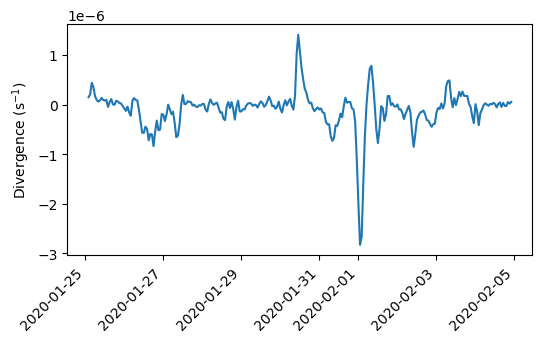

In [12]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(strain_rates['divergence'])
ax.set_ylabel('Divergence (s$^{-1}$)')
plt.xticks(rotation=45, ha='right');

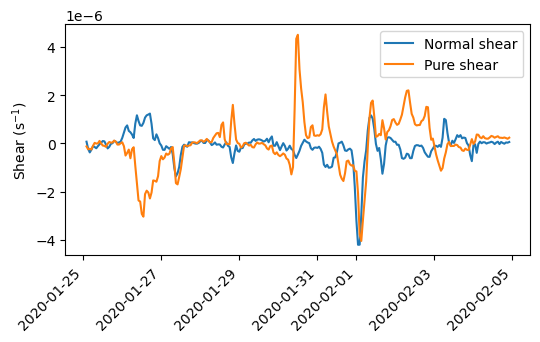

In [13]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(strain_rates['normal_shear'], label='Normal shear')
ax.plot(strain_rates['pure_shear'], label='Pure shear')
ax.set_ylabel('Shear (s$^{-1}$)')
ax.legend()
plt.xticks(rotation=45, ha='right');


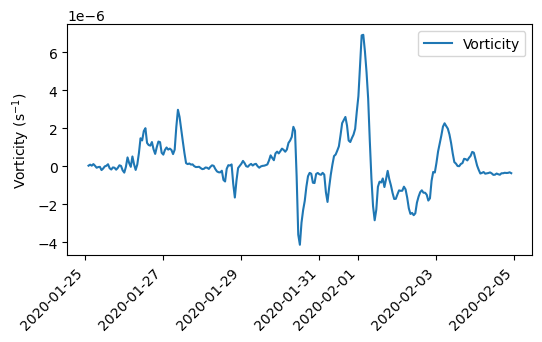

In [14]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(strain_rates['vorticity'], label='Vorticity')
ax.set_ylabel('Vorticity (s$^{-1}$)')
ax.legend()
plt.xticks(rotation=45, ha='right');


In [15]:
strain_rates.to_csv('../data/test_Lsite_strainrates.csv')

## Comparison with Jenny Hutching's data

In [16]:
df_jkh = pd.read_csv('../Ltriangle_standard.csv', index_col=0, parse_dates=True)
df_jkh_old = pd.read_csv('../Ltriangle_oldBug.csv', index_col=0, parse_dates=True)
df_jkh.columns = [x.strip() for x in df_jkh.columns]
df_jkh_old.columns = [x.strip() for x in df_jkh.columns]

df_jkh['dvdy'] = df_jkh['normal shear'] - df_jkh['dudx']
df_jkh_old['dvdy'] = df_jkh_old['normal shear'] - df_jkh_old['dudx']

In [17]:

df_jkh['dvdx'] = 0.5*(df_jkh['vorticity'] + df_jkh['pure shear'])
df_jkh['dvdy'] = 0.5*(df_jkh['divergence'] - df_jkh['normal shear'])
df_jkh['dudx'] = 0.5*(df_jkh['divergence'] + df_jkh['normal shear'])
df_jkh['dudy'] = 0.5*(df_jkh['pure shear'] - df_jkh['vorticity'])

df_jkh_old['dvdx'] = 0.5*(df_jkh_old['vorticity'] + df_jkh_old['pure shear'])
df_jkh_old['dvdy'] = 0.5*(df_jkh_old['divergence'] - df_jkh_old['normal shear'])
df_jkh_old['dudx'] = 0.5*(df_jkh_old['divergence'] + df_jkh_old['normal shear'])
df_jkh_old['dudy'] = 0.5*(df_jkh_old['pure shear'] - df_jkh_old['vorticity'])




Text(0.5, 1.0, 'Flipped sign settings')

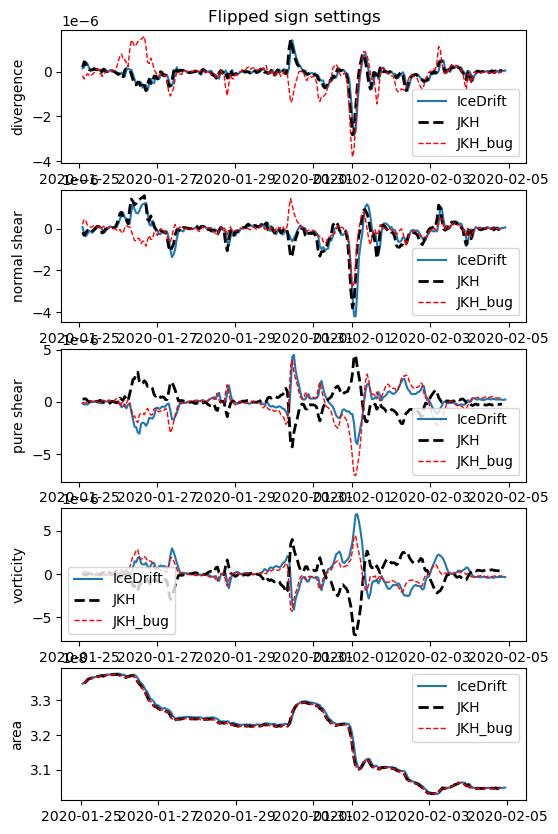

In [18]:
fig, axs = plt.subplots(figsize=(6, 10), nrows=5)
for ax, variable in zip(axs, ['divergence', 'normal shear', 'pure shear', 'vorticity', 'area']):
    ax.plot(strain_rates[variable.replace(' ', '_')], color='tab:blue', label='IceDrift')
    ax.plot(df_jkh[variable], color='k',  ls='--', label='JKH', lw=2)
    ax.plot(df_jkh_old[variable], color='r',  ls='--', label='JKH_bug', lw=1)
    ax.set_ylabel(variable)
    ax.legend()
axs[0].set_title('Flipped sign settings')

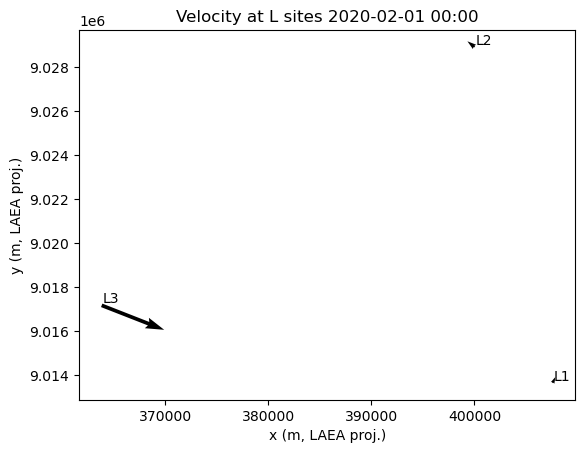

In [29]:
fig, ax  = plt.subplots()
date = '2020-02-01 00:00'
ax.quiver(strain_rates.loc[date, ['L1_xcoord', 'L2_xcoord', 'L3_xcoord']],
           strain_rates.loc[date, ['L1_ycoord', 'L2_ycoord', 'L3_ycoord']],
         strain_rates.loc[date, ['L1_uvel', 'L2_uvel', 'L3_uvel']],
           strain_rates.loc[date, ['L1_vvel', 'L2_vvel', 'L3_vvel']])
ax.set_xlabel('x (m, LAEA proj.)')
ax.set_ylabel('y (m, LAEA proj.)')
ax.set_title('Velocity at L sites ' + date)
for x, y, site in zip(strain_rates.loc[date, ['L1_xcoord', 'L2_xcoord', 'L3_xcoord']],
               strain_rates.loc[date, ['L1_ycoord', 'L2_ycoord', 'L3_ycoord']],
                     ['L1', 'L2', 'L3']):
    ax.text(x+1e2, y+1e2, site)

The above snapshot for Feb 1 at 0Z shows:
- dudx should be negative
- dudy should be negative
- dvdx should be positive
- dvdy should be positive

Could it be that the grids are different between IDL and the grid I'm using?

Text(0.5, 1.0, 'Standard')

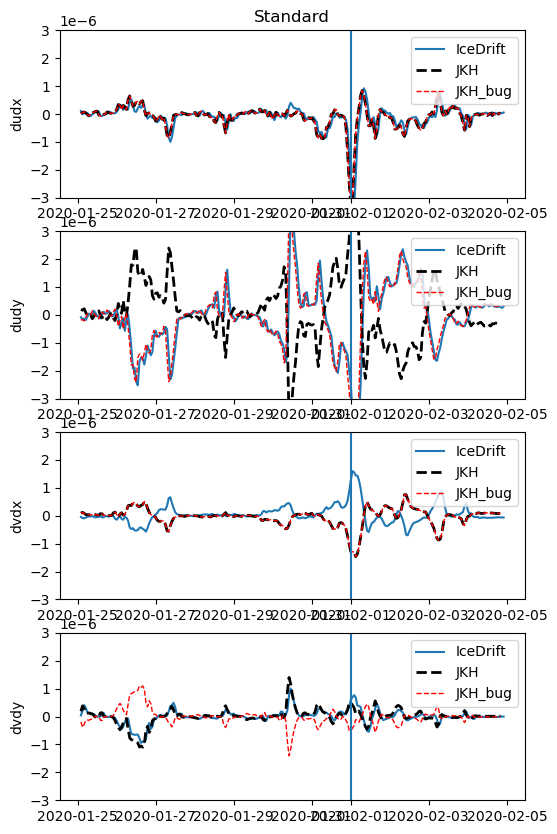

In [20]:
fig, axs = plt.subplots(figsize=(6, 10), nrows=4)
for ax, variable in zip(axs, ['dudx', 'dudy', 'dvdx', 'dvdy']):
    ax.plot(strain_rates['mean_' + variable], color='tab:blue', label='IceDrift')
    ax.plot(df_jkh[variable], color='k',  ls='--', label='JKH', lw=2)
    ax.plot(df_jkh_old[variable], color='r',  ls='--', label='JKH_bug', lw=1)
    ax.set_ylabel(variable)
    ax.legend(loc='upper right')
    ax.set_ylim(-3e-6, 3e-6)
    ax.axvline(pd.to_datetime(date))
axs[0].set_title('Standard')

In [13]:
# dvdx and dudy are the ones that don't match

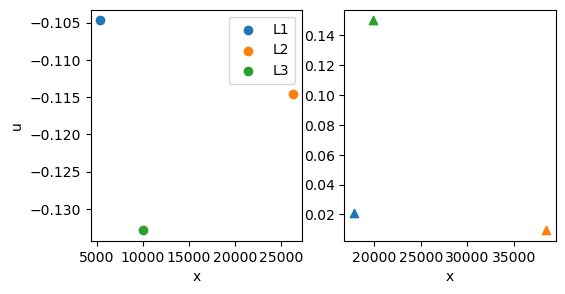

In [14]:

fig, ax = plt.subplots(ncols=2, figsize=(6, 3))
date1 = '2020-01-26 12:00'
for site in buoy_data:
    ax[0].scatter(buoy_data[site].loc[date1,'x_stere'],
               buoy_data[site].loc[date1,'u'], label=site, marker='o')
date2 = '2020-02-01 01:00'
for site in buoy_data:
    ax[1].scatter(buoy_data[site].loc[date2,'x_stere'],
               buoy_data[site].loc[date2,'u'], label=site, marker='^')
    
ax[0].set_xlabel('x')
ax[1].set_xlabel('x')
ax[0].set_ylabel('u')
ax[0].legend()

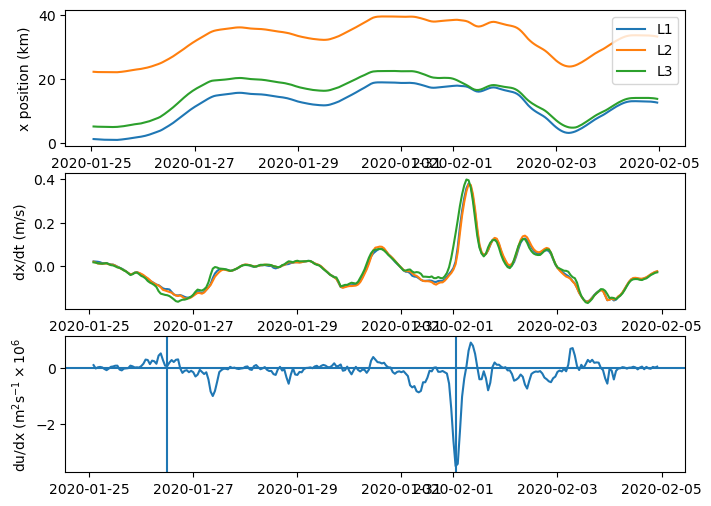

In [15]:
fig, axs = plt.subplots(figsize=(8, 6), nrows=3)
for site in buoy_data:
    axs[0].plot(buoy_data[site]['x_stere']/1e3, label=site)
    axs[1].plot(buoy_data[site]['u'], label=site)
axs[2].plot(strain_rates['mean_dudx']*1e6)
axs[2].axhline(0)
axs[2].axvline(pd.to_datetime(date1))
axs[2].axvline(pd.to_datetime(date2))
axs[0].set_ylabel('x position (km)')
axs[1].set_ylabel('dx/dt (m/s)')
axs[2].set_ylabel('du/dx (m$^2$s$^{-1} \\times 10^6$')
axs[0].legend()

Text(0, 0.5, 'u')

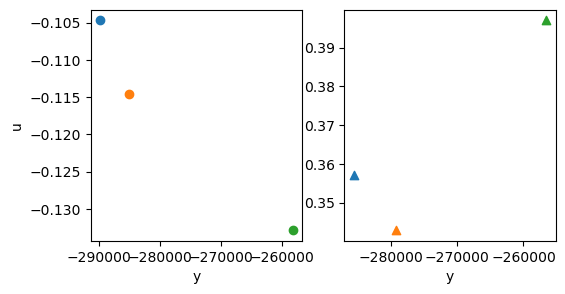

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(6, 3))
date1 = '2020-01-26 12:00'
for site in buoy_data:
    ax[0].scatter(buoy_data[site].loc[date1,'y_stere'],
               buoy_data[site].loc[date1,'u'], label=site, marker='o')
date2 = '2020-02-01 06:00'
for site in buoy_data:
    ax[1].scatter(buoy_data[site].loc[date2,'y_stere'],
               buoy_data[site].loc[date2,'u'], label=site, marker='^')
    
ax[0].set_xlabel('y')
ax[1].set_xlabel('y')
ax[0].set_ylabel('u')

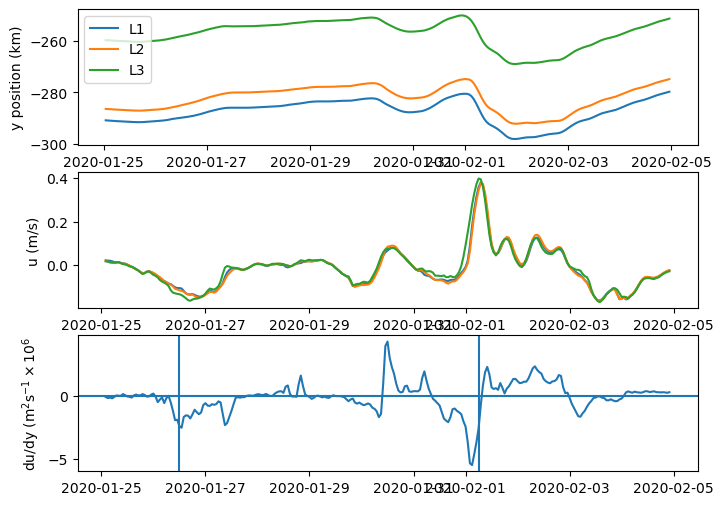

In [17]:
fig, axs = plt.subplots(figsize=(8, 6), nrows=3)
for site in buoy_data:
    axs[0].plot(buoy_data[site]['y_stere']/1e3, label=site)
    axs[1].plot(buoy_data[site]['u'], label=site)
axs[2].plot(strain_rates['mean_dudy']*1e6)
axs[2].axhline(0)
axs[0].set_ylabel('y position (km)')
axs[1].set_ylabel('u (m/s)')
axs[2].set_ylabel('du/dy (m$^2$s$^{-1} \\times 10^6$')
axs[0].legend()
axs[2].axvline(pd.to_datetime(date1))
axs[2].axvline(pd.to_datetime(date2))

Text(0, 0.5, 'v')

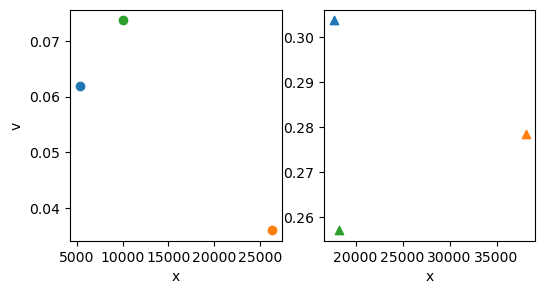

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(6, 3))
date1 = '2020-01-26 12:00'
for site in buoy_data:
    ax[0].scatter(buoy_data[site].loc[date1,'x_stere'],
               buoy_data[site].loc[date1,'v'], label=site, marker='o')
date2 = '2020-02-01 06:00'
for site in buoy_data:
    ax[1].scatter(buoy_data[site].loc[date2,'x_stere'],
               buoy_data[site].loc[date2,'v'], label=site, marker='^')
    
ax[0].set_xlabel('x')
ax[1].set_xlabel('x')
ax[0].set_ylabel('v')

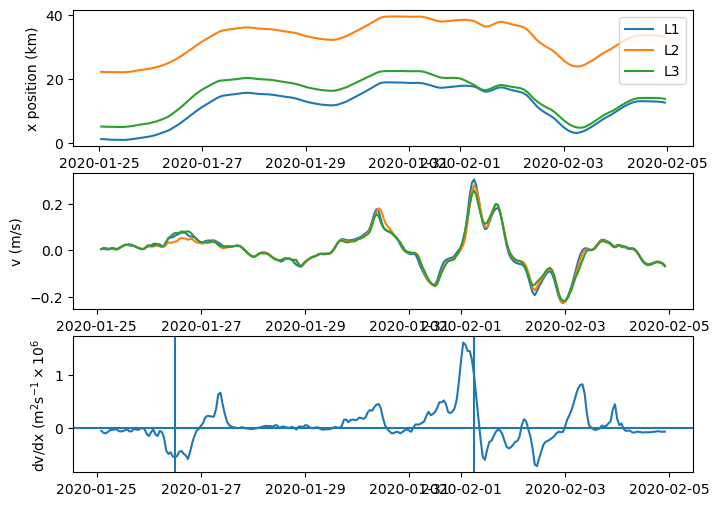

In [19]:
fig, axs = plt.subplots(figsize=(8, 6), nrows=3)
for site in buoy_data:
    axs[0].plot(buoy_data[site]['x_stere']/1e3, label=site)
    axs[1].plot(buoy_data[site]['v'], label=site)
axs[2].plot(strain_rates['mean_dvdx']*1e6)
axs[2].axhline(0)
axs[0].set_ylabel('x position (km)')
axs[1].set_ylabel('v (m/s)')
axs[2].set_ylabel('dv/dx (m$^2$s$^{-1} \\times 10^6$')
axs[0].legend()
axs[2].axvline(pd.to_datetime(date1))
axs[2].axvline(pd.to_datetime(date2))

In [20]:
import pyproj
projIn = 'WGS84'
projOut = '+proj=laea +lat_0=0 +lon_0=0 +x_0=0 +y_0=0 +a=6370997.0 +b=6370997.0 +units=m +no_defs +type=crs'
transformer_jkh_comp = pyproj.Transformer.from_crs(projIn, projOut, always_xy=True)
    
for site in buoy_data:
    x, y  = transformer_jkh_comp.transform(buoy_data[site].longitude, buoy_data[site].latitude)
    buoy_data[site]['x_laea'] = x
    buoy_data[site]['y_laea'] = y

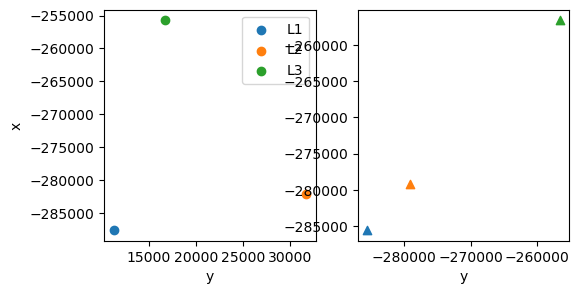

In [21]:
fig, ax = plt.subplots(ncols=2, figsize=(6, 3))
date1 = '2020-01-27 0:00'
for site in buoy_data:
    # set up transformer for test: laea with all 0 defaults, spherical earth
    
    ax[0].scatter(buoy_data[site].loc[date1,'x_stere'],
               buoy_data[site].loc[date1,'y_stere'], label=site, marker='o')
date2 = '2020-02-01 06:00'
for site in buoy_data:
    ax[1].scatter(buoy_data[site].loc[date2,'y_stere'],
               buoy_data[site].loc[date2,'y_stere'], label=site, marker='^')
    
ax[0].set_xlabel('y')
ax[1].set_xlabel('y')
ax[0].set_ylabel('x')
ax[0].legend()

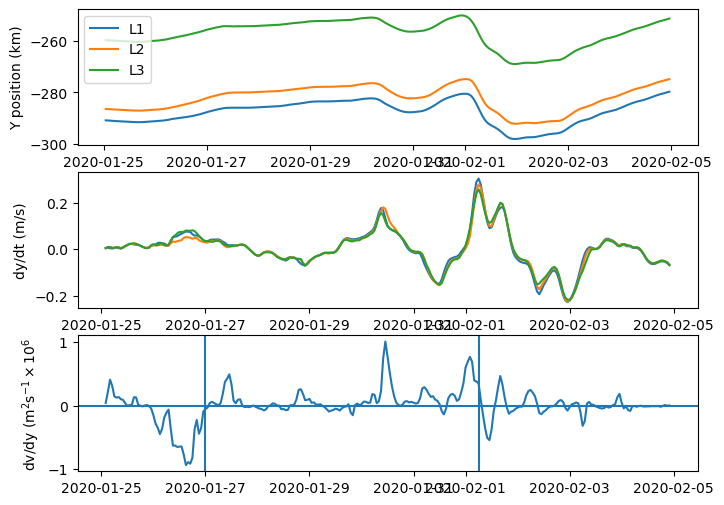

In [22]:
fig, axs = plt.subplots(figsize=(8, 6), nrows=3)
for site in buoy_data:
    axs[0].plot(buoy_data[site]['y_stere']/1e3, label=site)
    axs[1].plot(buoy_data[site]['v'], label=site)
axs[2].plot(strain_rates['mean_dvdy']*1e6)
axs[2].axhline(0)
axs[0].set_ylabel('Y position (km)')
axs[1].set_ylabel('dy/dt (m/s)')
axs[2].set_ylabel('dv/dy (m$^2$s$^{-1} \\times 10^6$')
axs[0].legend()
axs[2].axvline(pd.to_datetime(date1))
axs[2].axvline(pd.to_datetime(date2))